# Imports

In [58]:
import os, gc
import torch
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)

# Initial setup

## GPU

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Google colab

Set `running_on_colab` to true if you are running on google colab. They don't have these libraries installed by default.Uncomment the codes too if needed. They might be commented out since in .py script inline commands show errors.

**Restart the kernel after installing the new libraries.**

In [ ]:
# running_on_colab = True

# if running_on_colab:
#     !pip install torch==1.11.0
#     # !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
#     !pip install pytorch_lightning==1.8.1
#     !pip install pytorch_forecasting==0.10.3
#     !pip install pandas==1.4.1

In [ ]:
# if running_on_colab:
#     from google.colab import drive

#     drive.mount('/content/drive')
#     %cd /content/drive/My Drive/TFT-pytorch/notebook

## Pytorch lightning and forecasting

In [3]:
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer

# Load input

In [55]:
from dataclasses import dataclass

@dataclass
class args:
    result_folder = '../results/TFT_baseline/' 
    figPath = os.path.join(result_folder, 'figures_morris')
    checkpoint_folder = os.path.join(result_folder, 'checkpoints')
    input_filePath = '../2022_May_cleaned/Top_100.csv'

    configPath = '../configurations/baseline.json'
    model_path = os.path.join(checkpoint_folder, 'best-epoch=4.ckpt')

    # set this to false when submitting batch script, otherwise it prints a lot of lines
    show_progress_bar = True

if not os.path.exists(args.figPath):
    os.makedirs(args.figPath, exist_ok=True)

In [5]:
start = datetime.now()
print(f'Started at {start}')

total_data = pd.read_csv(args.input_filePath)
print(total_data.shape)
total_data.head()

Started at 2023-01-29 22:30:24.432030
(80900, 12)


,FIPS,AgeDist,HealthDisp,Date,DiseaseSpread,Transmission,VaccinationFull,SocialDist,Cases,TimeFromStart,SinWeekly,CosWeekly
0,2261,0.014,8.8,2020-02-29,0.0,0.0,0.0,0.5,0.0,0,-0.975,-0.223
1,2261,0.014,8.8,2020-03-01,0.0,0.0,0.0,0.5,0.0,1,-0.782,0.623
2,2261,0.014,8.8,2020-03-02,0.0,0.0,0.0,0.5,0.0,2,0.000,1.000
3,2261,0.014,8.8,2020-03-03,0.0,0.0,0.0,0.5,0.0,3,0.782,0.623
4,2261,0.014,8.8,2020-03-04,0.0,0.0,0.0,0.5,0.0,4,0.975,-0.223


# Config

In [6]:
import json
import sys
sys.path.append( '..' )
from Class.Parameters import Parameters
from script.utils import *

with open(args.configPath, 'r') as input_file:
  config = json.load(input_file)

parameters = Parameters(config, **config)

In [7]:
targets = parameters.data.targets
time_idx = parameters.data.time_idx
tft_params = parameters.model_parameters

batch_size = tft_params.batch_size
max_prediction_length = tft_params.target_sequence_length
max_encoder_length = tft_params.input_sequence_length

# Processing

In [8]:
total_data['Date'] = pd.to_datetime(total_data['Date'].values) 
total_data['FIPS'] = total_data['FIPS'].astype(str)
print(f"There are {total_data['FIPS'].nunique()} unique counties in the dataset.")

There are 100 unique counties in the dataset.


## Adapt input to encoder length
Input data length needs to be a multiple of encoder length to created batch data loaders.

In [9]:
train_start = parameters.data.split.train_start
total_data = total_data[total_data['Date']>=train_start]
total_data[time_idx] = (total_data["Date"] - total_data["Date"].min()).apply(lambda x: x.days)

## Train validation test split and scaling

In [10]:
train_data, validation_data, test_data = train_validation_test_split(
    total_data, parameters
)

Train samples 64000, validation samples 2800, test samples 2800
640 days of training, 15 days of validation data, 15 days of test data.


In [11]:
train_scaled, validation_scaled, test_scaled, target_scaler = scale_data(
    train_data, validation_data, test_data, parameters
)

Scaling static and dynamic input features: ['AgeDist', 'HealthDisp', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist']
Scaling targets ['Cases']


## Create dataset and dataloaders

In [12]:
def prepare_data(data: pd.DataFrame, pm: Parameters, train=False):
  data_timeseries = TimeSeriesDataSet(
    data,
    time_idx= time_idx,
    target=targets,
    group_ids=pm.data.id, 
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals=pm.data.static_features,
    # static_categoricals=['FIPS'],
    time_varying_known_reals = pm.data.time_varying_known_features,
    time_varying_unknown_reals = pm.data.time_varying_unknown_features,
    target_normalizer = MultiNormalizer(
      [GroupNormalizer(groups=pm.data.id) for _ in range(len(targets))]
    )
  )

  if train:
    dataloader = data_timeseries.to_dataloader(train=True, batch_size=batch_size)
  else:
    dataloader = data_timeseries.to_dataloader(train=False, batch_size=batch_size*8)

  return dataloader

In [13]:
train_dataloader = prepare_data(train_scaled, parameters)
validation_dataloader = prepare_data(validation_scaled, parameters)
test_dataloader = prepare_data(test_scaled, parameters)

# del validation_scaled, test_scaled
gc.collect()

19878

# Model

In [14]:
tft = TemporalFusionTransformer.load_from_checkpoint(args.model_path)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 20.4k


# Prediction Processor and PlotResults

In [15]:
from Class.PredictionProcessor import PredictionProcessor

processor = PredictionProcessor(
    time_idx, parameters.data.id[0], max_prediction_length, targets, 
    train_start, max_encoder_length
)

In [16]:
from Class.Plotter import *

plotter = PlotResults(args.figPath, targets, show=args.show_progress_bar)

Creating folder ../results/TFT_baseline/figures_morris_version_1


# Evaluate

## Train results

### Average


---Training results--



Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Target Cases, MAE 106.01, RMSE 281.77, RMSLE 1.4738, SMAPE 0.56814. NNSE 0.83955.



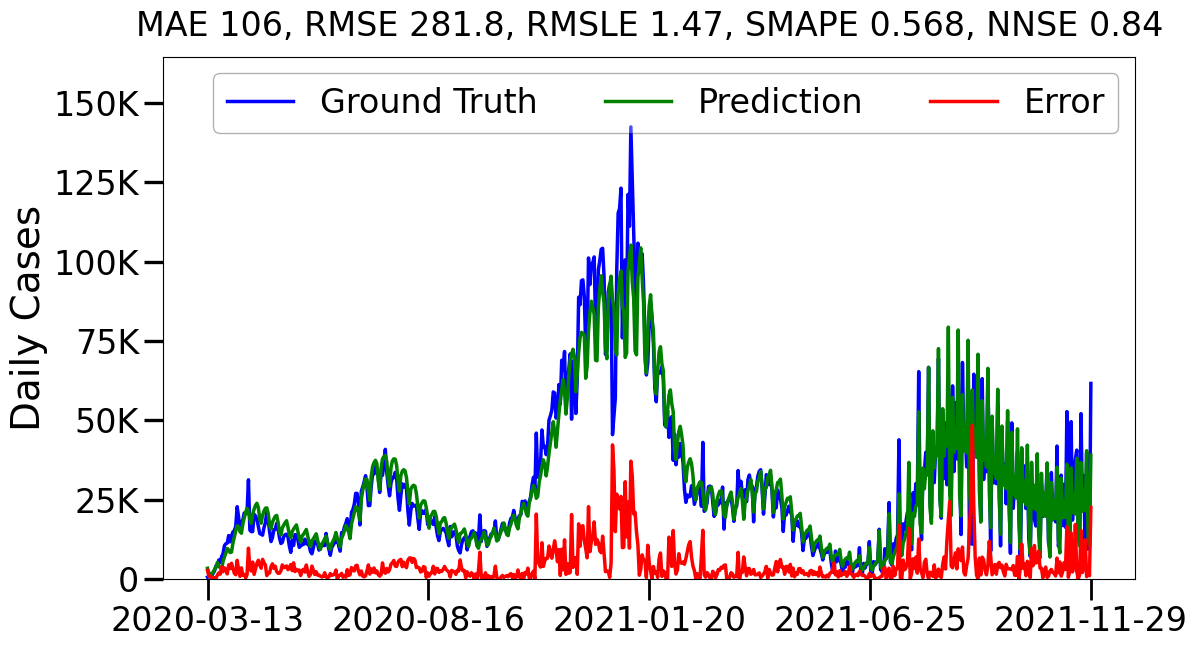

3584

In [17]:
print(f'\n---Training results--\n')

# [number of targets (2), number of examples, prediction length (15)]
train_raw_predictions, train_index = tft.predict(
    train_dataloader, return_index=True, show_progress_bar=args.show_progress_bar
)

train_predictions = upscale_prediction(targets, train_raw_predictions, target_scaler, max_prediction_length)
train_result_merged = processor.align_result_with_dataset(train_data, train_predictions, train_index)
show_result(train_result_merged, targets)

plotter.summed_plot(train_result_merged, type='Train_error', plot_error=True, save=False)
gc.collect()

# Morris method

## Scale

In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

features = parameters.data.static_features + parameters.data.dynamic_features

minmax_scaler = MinMaxScaler()
train_minmax_scaled = minmax_scaler.fit_transform(train_data[features])

target_minmax_scaler = MinMaxScaler().fit(train_data[targets])

standard_scaler = StandardScaler()
standard_scaler.fit(train_data[features])

StandardScaler()

## Calculate

In [51]:
# delta_values = [1e-2, 1e-3, 5e-3, 9e-3, 5e-4, 1e-4, 5e-5, 1e-5]
delta_values = [1e-2, 1e-3, 1e-4]
results = {
    'Delta': [],
    'Feature': [],
    'Mu_star':[],
    'Morris_sensitivity':[] 
}

In [53]:
for delta in delta_values:
    print(f'Delta {delta}.')
    for index, feature in enumerate(features):
        # this mimics how TF1 did it
        data = train_minmax_scaled.copy()
        data[index] += delta
        data = minmax_scaler.inverse_transform(data) # return to original scale

        # replace the value in normalized data
        data = standard_scaler.transform(data)
        train_scaled_copy = train_scaled.copy()
        train_scaled_copy[feature] = data[:, index]

        # inference on delta changed data
        dataloader = prepare_data(train_scaled_copy, parameters)
        new_predictions = tft.predict(
            dataloader, show_progress_bar=args.show_progress_bar
        )

        # sum up the change in prediction
        prediction_change = np.sum([
            (train_raw_predictions[target_index] - new_predictions[target_index]).abs().numpy() 
                for target_index in range(len(targets)) 
        ])
        mu_star = prediction_change / (data.shape[0]*delta)

        # since delta is added to min max normalized value, std from same scaling is needed
        standard_deviation = train_minmax_scaled[:, index].std()
        scaled_morris_index = mu_star * standard_deviation

        print(f'Feature {feature}, mu_star {mu_star:0.5g}, sensitivity {scaled_morris_index:0.5g}')

        results['Delta'].append(delta)
        results['Feature'].append(feature)
        results['Mu_star'].append(mu_star)
        results['Morris_sensitivity'].append(scaled_morris_index)
    print()
    # break

Delta 0.01.


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Feature AgeDist, mu_star 0.00041691, sensitivity 5.103e-05, std 0.1224


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Feature HealthDisp, mu_star 0.00032675, sensitivity 5.4185e-05, std 0.16583


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Feature DiseaseSpread, mu_star 0.001996, sensitivity 5.8417e-05, std 0.029267


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Feature Transmission, mu_star 0.00029947, sensitivity 2.8968e-05, std 0.096732


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Feature VaccinationFull, mu_star 0.00029739, sensitivity 9.0758e-05, std 0.30518


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Feature SocialDist, mu_star 0.00029739, sensitivity 3.5635e-05, std 0.11983



## Dump

In [56]:
import pandas as pd
result_df = pd.DataFrame(results)
result_df.to_csv(os.path.join(args.figPath, 'Morris.csv'), index=False)
result_df

,Delta,Feature,Mu_star,Morris_sensitivity
0,0.01,AgeDist,0.000417,0.000051
1,0.01,HealthDisp,0.000327,0.000054
2,0.01,DiseaseSpread,0.001996,0.000058
3,0.01,Transmission,0.000299,0.000029
4,0.01,VaccinationFull,0.000297,0.000091
5,0.01,SocialDist,0.000297,0.000036


## Plot

In [27]:
from Class.PlotConfig import *

0.01


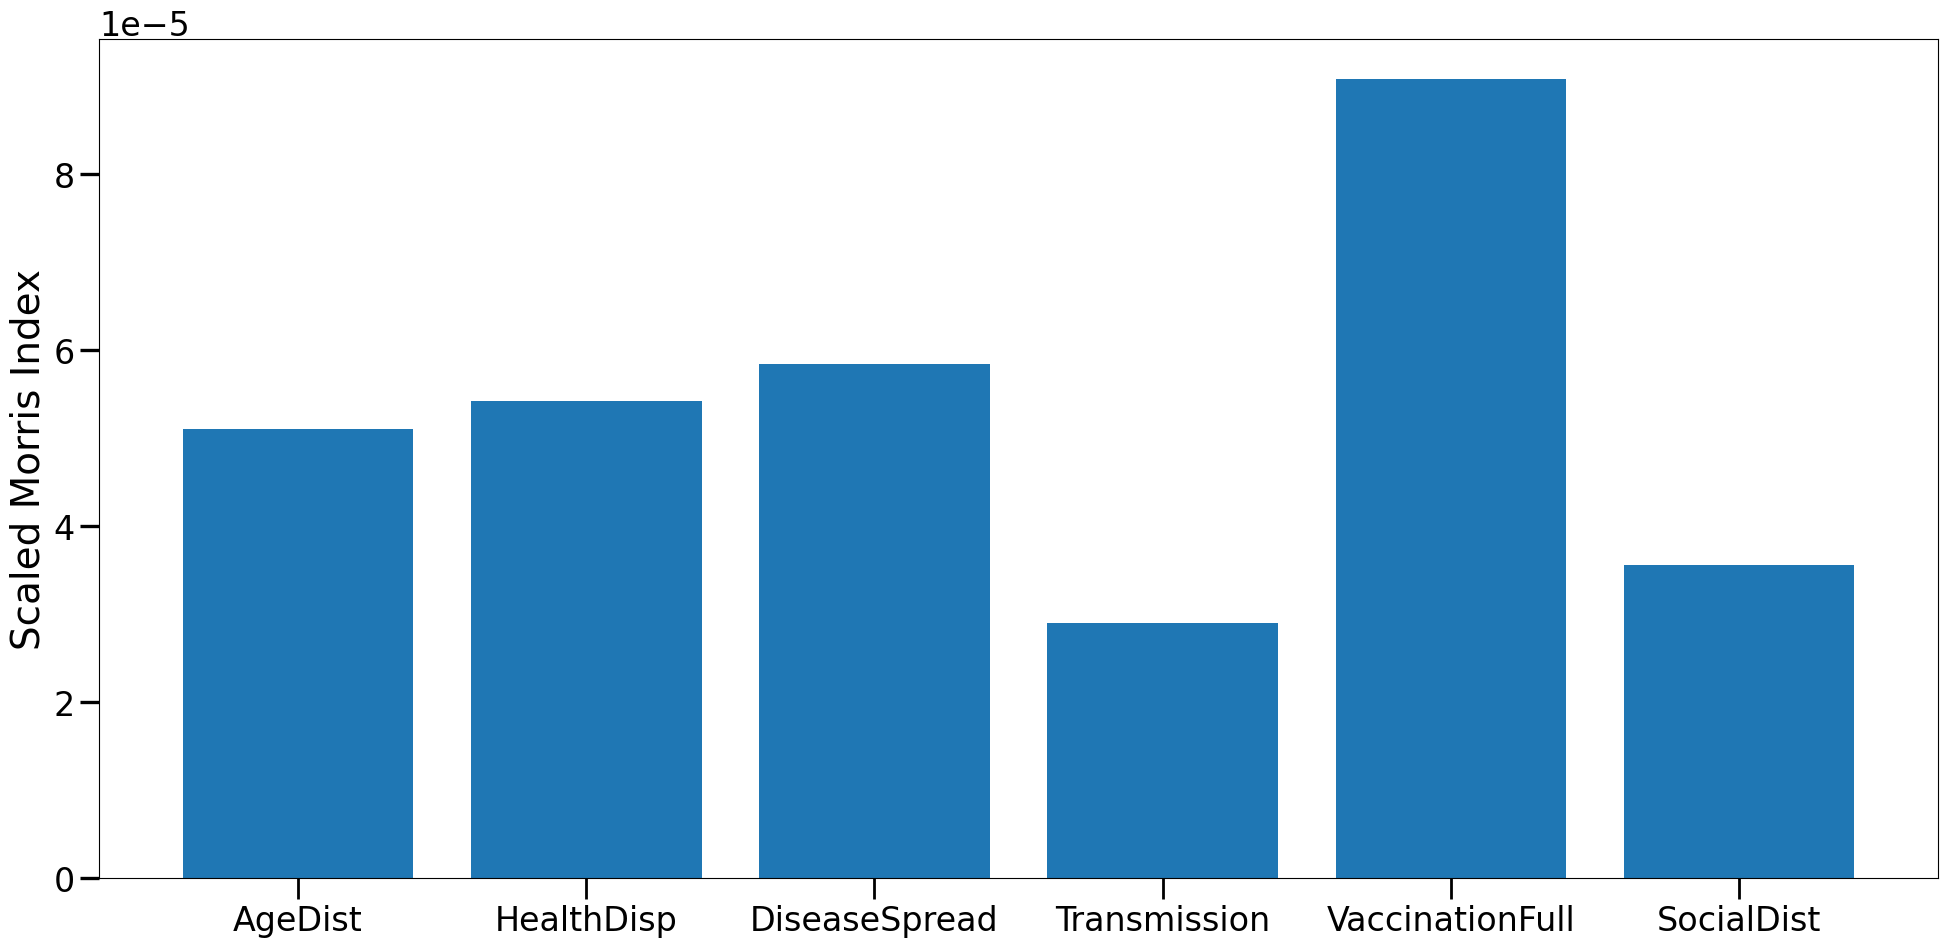

In [57]:
for delta in delta_values:
    print(delta)
    fig = plt.figure(figsize = (20, 10))
    plt.bar(features, result_df[result_df['Delta']==delta]['Morris_sensitivity'])
    
    plt.ylabel("Scaled Morris Index")
    plt.tight_layout()
    plt.savefig(os.path.join(args.figPath, f'delta_{delta}.jpg'), dpi=200)
    plt.show()
    # break

# End

In [ ]:
print(f'Ended at {datetime.now()}. Elapsed time {datetime.now() - start}')